# Kidney Stone Prediction based on Urine Analysis

In [199]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import random

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, precision_score, roc_auc_score
from sklearn.model_selection import cross_val_predict, train_test_split, KFold,cross_val_score


%matplotlib inline

## Table of Contents
1. [Project Scope](## Project Scope)
2. [Data Overview](## Data Overview)
3. [Exploratory Analysis](## Exploratory Analysis)
4. [Principal Component Analysis](## Principal Component Analysis)
5. [Random Forest](## Random Forest)
6. [K Neighbors Classifier](## K Neighbors Classifier)
7. [Logistic Regression](## Logistic Regression)
8. [Conclusion](## Conclusion)

## Project Scope

My objective is find best model to predict the probability of a kidney stone being present in a sample of data collected from urinalysis. The classification models used will be Random Forest Classifier, K Neighbors Classifier, and Logistic Regression. The first two models' hyperparameters will be fine tuned to produce best accuracy, while the last model will also serve as a benchmark for the other two because of its simplicity. Performance is evaluated on area under the ROC curve between the predicted probability and the observed target and confusion matrix metrics like precision, false positive rate, true positive rate.

## Data Overview

This dataset was downloaded from Vuppala Adithya Sairam's Kaggle which is originally obtained from 'Physical Characteristics of Urines With and Without Crystals',a chapter from Springer Series in Statistics. 

Kaggle datasource - https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis

Original source - https://link.springer.com/chapter/10.1007/978-1-4612-5098-2_45

The 79 urine specimens, were analyzed in an effort to determine if certain physical characteristics of the urine might be related to thenformation of calcium oxalate crystals.
The six physical characteristics of the urine are: 

1. **gravity** - specific gravity, the density of the urine relative to water; 

2. **pH** - pH, the negative logarithm of the hydrogen ion; 

3. **osmo** - osmolarity (mOsm), a unit used in biology and medicine but not in
physical chemistry. Osmolarity is proportional to the concentration of
molecules in solution; 

4. **cond** - conductivity (mMho milliMho). One Mho is one reciprocal Ohm. Conductivity is proportional to the concentration of charged
ions in solution; 

5. **urea** - urea concentration in millimoles per litre; and 

6. **calc** - calcium concentration (CALC) in millimolesllitre.

The target value of 1 indicates presence of calcium oxalate crystals or kidney stones and value of 0 indicate no presence.


In [51]:
train = pd.read_csv("train.csv",index_col = 0)
print("Train dataset shape:",train.shape)

Train dataset shape: (414, 7)


In [3]:
train.head(5)

,gravity,ph,osmo,cond,urea,calc,target
id,,,,,,,
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


In [5]:
#identify columns with null values
missing_percentages = train.isna().sum().sort_values(ascending = False)/len(train)
missing_percentages

gravity    0.0
ph         0.0
osmo       0.0
cond       0.0
urea       0.0
calc       0.0
target     0.0
dtype: float64

In [213]:
#identify columns with duplicate values
duplicate = train[train.duplicated()]
duplicate

,gravity,ph,osmo,cond,urea,calc,target,PC1,PC2,PC3,PC4
id,,,,,,,,,,,


There are 413 specimens found within the dataset and there are no null values or duplicates found.

## Exploratory Analysis

In [6]:
#What is the probability of kidney stone?
 
train.target.value_counts(normalize=True)

0    0.555556
1    0.444444
Name: target, dtype: float64

The probability of kidney stone found is 44% so it's very balanced dataset and we do not have any null values.

In [7]:
predictors = train.drop(columns = ["target"])

predictors.describe()

,gravity,ph,osmo,cond,urea,calc
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638
std,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000
25%,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000
50%,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000
75%,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000
max,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000


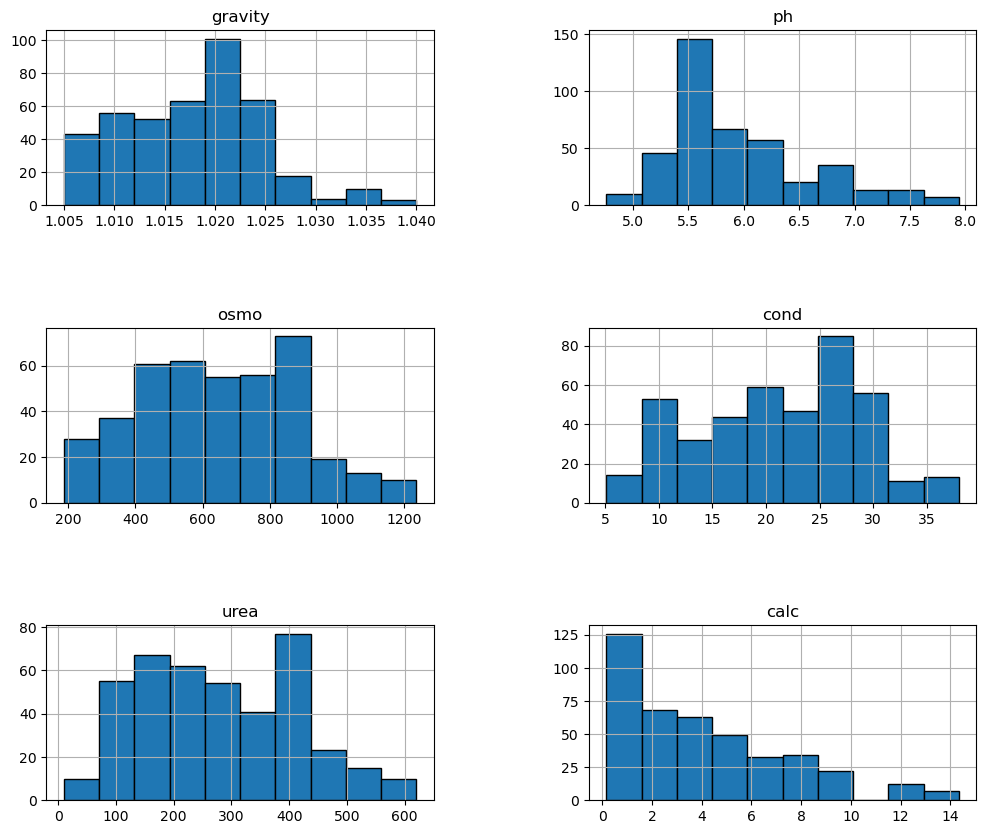

In [8]:
#histogram distribution of quantitative variables
predictors.hist(figsize=(12, 10), bins=10, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

All of the predicting features do not have multivariate normal distribution, which is understandable given the nature of the data. The values are all positive and appear to be evenly distributed or right skewed. Specifically, gravity and calc have outliers toward the right tail of the distribution. 

Below I have provided a brief understanding of these features to help understand the distribution better:

1. **gravity** - Typical healthy range of density of the urine relative to water is 1.005 to 1.030.

2. **pH** - Typical healthy range is 4.5 to 8. pH 7 is neutral. However, pH under 5.5 is also associated with uric acid crystals which promotes formation of calcium oxalate crystals.

3. **osmo** - Concentration of molecules/particles found in urine. Typical healthy range is 50 to 1200 mmol/kg

4. **cond** - Amount of electrolytes, such as sodium, potassium, calcium, chloride, and nitrite, in urine. Unfortunately, it is unclear what kind ions were measured in this study.

5. **urea** - Waste byproduct of the breakdown of protein, which increases the amount of acid produced in the body. Low levels of urea is associated with kidney problems, or malnutrition from lack of protein. High urea means overactive kidneys or too much protein; Typical healthy range is 1.8 to 7.1 mmol/l.

6. **calc** - Typical healthy range is 2.50 to 7.50 mmol/24 hours. Levels higher than this range is associated with leaking of calcium from the kidneys into the urine which causes kidney stones.


In [9]:
# Correlation matrix
df_corr = predictors.corr()
round(df_corr,2)

,gravity,ph,osmo,cond,urea,calc
gravity,1.00,-0.29,0.69,0.47,0.63,0.49
ph,-0.29,1.00,-0.31,-0.19,-0.28,-0.21
osmo,0.69,-0.31,1.00,0.71,0.81,0.47
cond,0.47,-0.19,0.71,1.00,0.50,0.33
urea,0.63,-0.28,0.81,0.50,1.00,0.49
calc,0.49,-0.21,0.47,0.33,0.49,1.00


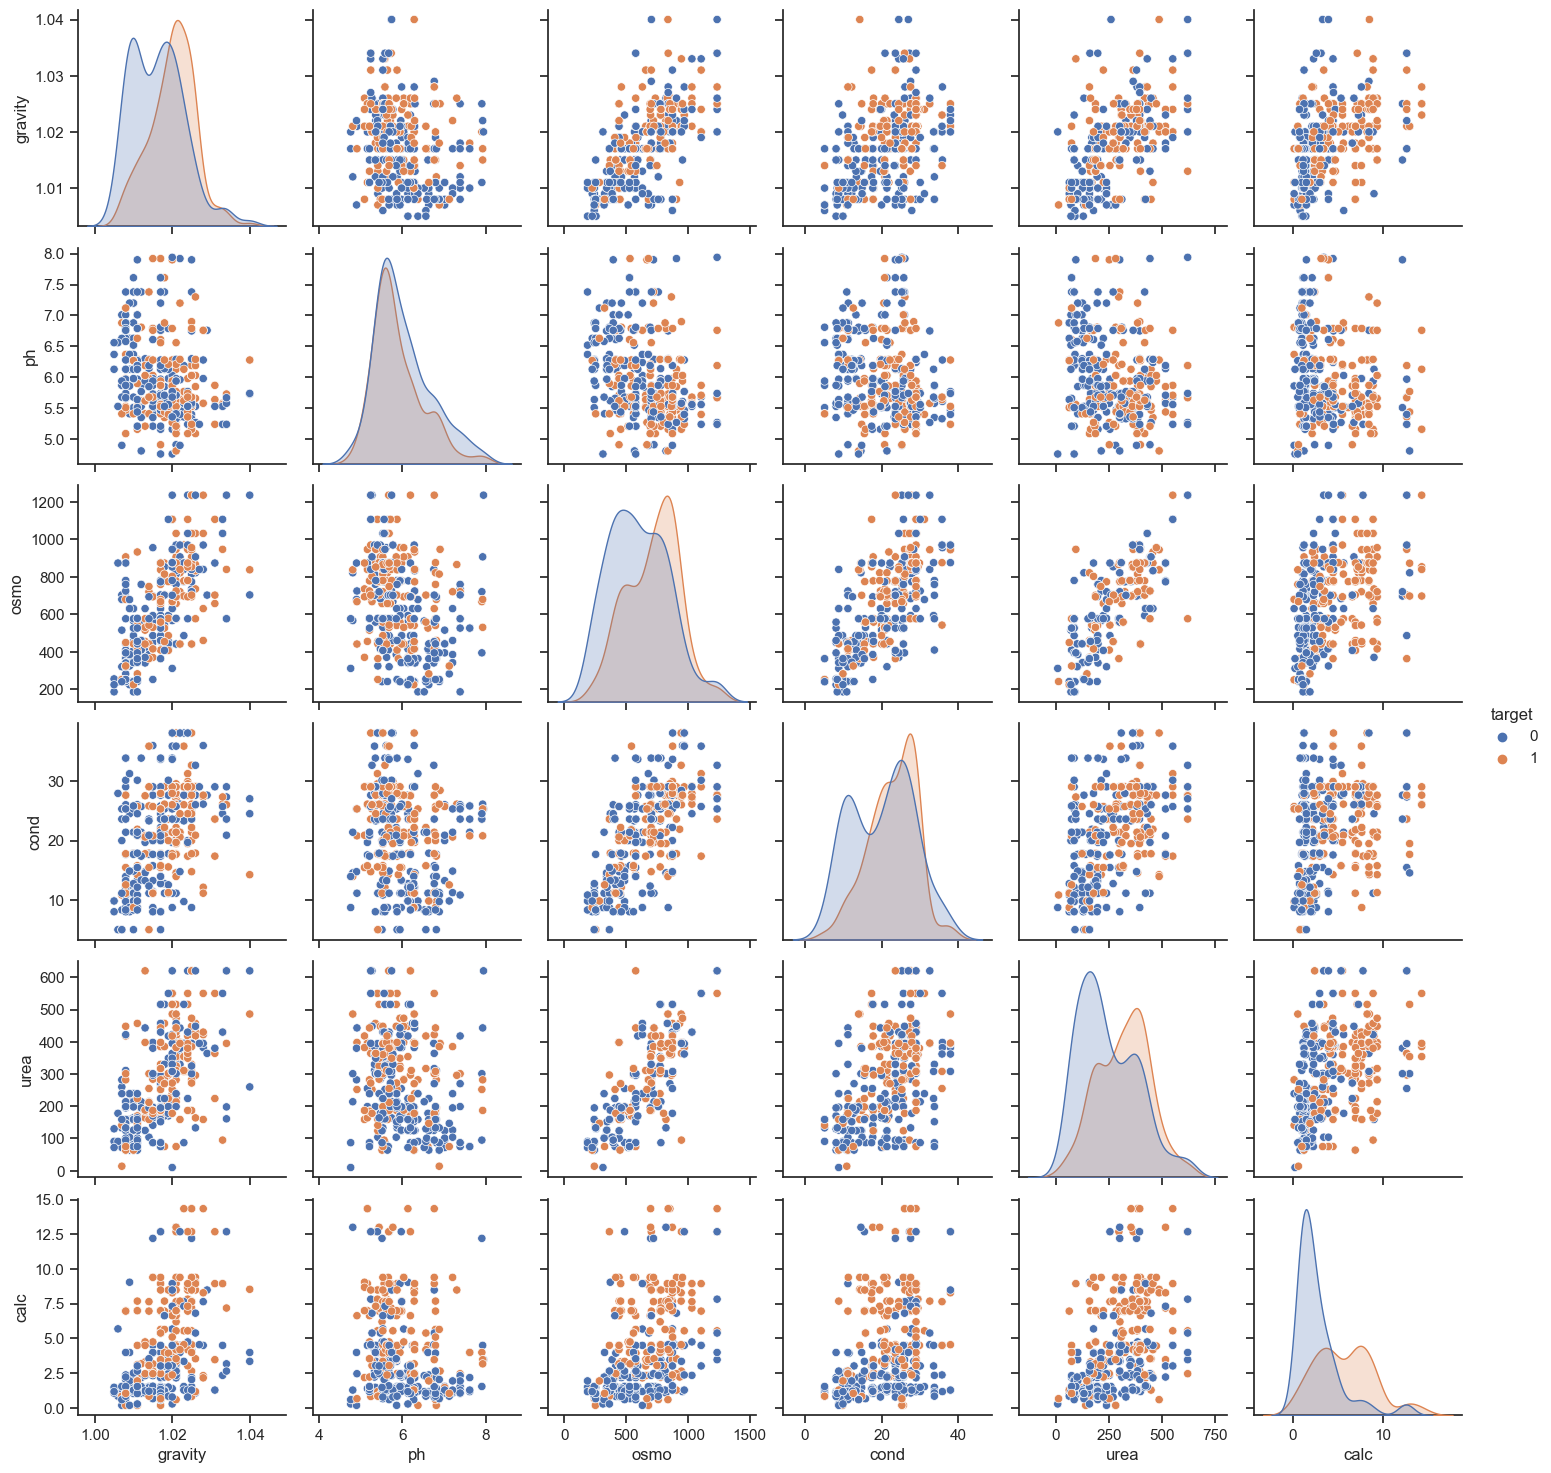

In [10]:
# Correlation matrix graph
sns.set_theme(style="ticks")

sns.pairplot(train, hue = 'target') 

plt.show()

There are strong multicollinearity issues between gravity vs. osmo (0.69), gravity vs. urea (0.63), osmo vs cond (0.71), osmo vs. urea (0.81), cond vs. urea (0.50).

Additionally, we can see in this view that cases with kidney stones seem to cause right skew found in the calc feature. Similarly, the median of the distribution of kidney stones cases appear larger than the cases with absence of the stones.

## Principal Component Analysis

The features of the data are somewhat skewed and present some multicollinearity issues. We specfically see that gravity, osmo, and urea having high correlations therefore it is reasonble to consider principal component analysis, which is a type of unsupervised learning. We will proceed with transforming the data using log and standard scaler then perform principal component analysis. Afterwards we will proceed with modeling the data to predict the target using various methods and compare the results. 

In [78]:
# log transform data
predictors_log = np.log(predictors)
    
# Scale data using standard scaler 
scaled = pd.DataFrame(scale(predictors_log), index=predictors_log.index, columns=predictors_log.columns)
round(scaled.describe(),2)

,gravity,ph,osmo,cond,urea,calc
count,414.00,414.00,414.00,414.00,414.00,414.00
mean,-0.00,0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.94,-2.11,-2.90,-3.22,-5.31,-3.27
25%,-0.88,-0.66,-0.70,-0.58,-0.58,-0.81
50%,0.02,-0.30,0.29,0.27,0.24,0.07
75%,0.62,0.57,0.81,0.78,0.79,0.93
max,3.29,2.83,1.77,1.54,1.59,1.81


In [79]:
# Now apply PCA and extract the loadings
pca = PCA().fit(scaled)
pca_loadings = pca.components_.T

pca_loadings = pd.DataFrame(pca_loadings, index=predictors_log.columns, columns=['V1', 'V2', 'V3', 'V4','V5','V6'])
pca_loadings

,V1,V2,V3,V4,V5,V6
gravity,-0.437367,-0.013322,-0.178332,0.453737,0.727539,0.203814
ph,0.235210,-0.947836,-0.089842,0.190094,-0.003811,-0.045413
osmo,-0.491969,-0.089210,0.292893,0.108702,-0.067912,-0.804856
cond,-0.408030,-0.279585,0.549333,-0.531986,0.104052,0.399676
urea,-0.449316,-0.030805,-0.058078,0.450908,-0.671020,0.374442
calc,-0.378126,-0.119814,-0.754453,-0.509749,-0.070463,-0.093041


In [80]:
# compute the principal components and store them in a dataframe
principal_components = PCA().fit_transform(scaled)
principal_components = pd.DataFrame(
                            data = principal_components, 
                            columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6'],
                            index=predictors_log.index)
principal_components.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6
id,,,,,,
0,1.886185,0.000446,0.164283,-0.048078,0.242287,-0.163820
1,-1.549546,0.609712,-0.124715,0.306313,0.213016,0.395588
2,0.877536,-0.461070,-0.798999,-1.904879,-0.469700,0.507387


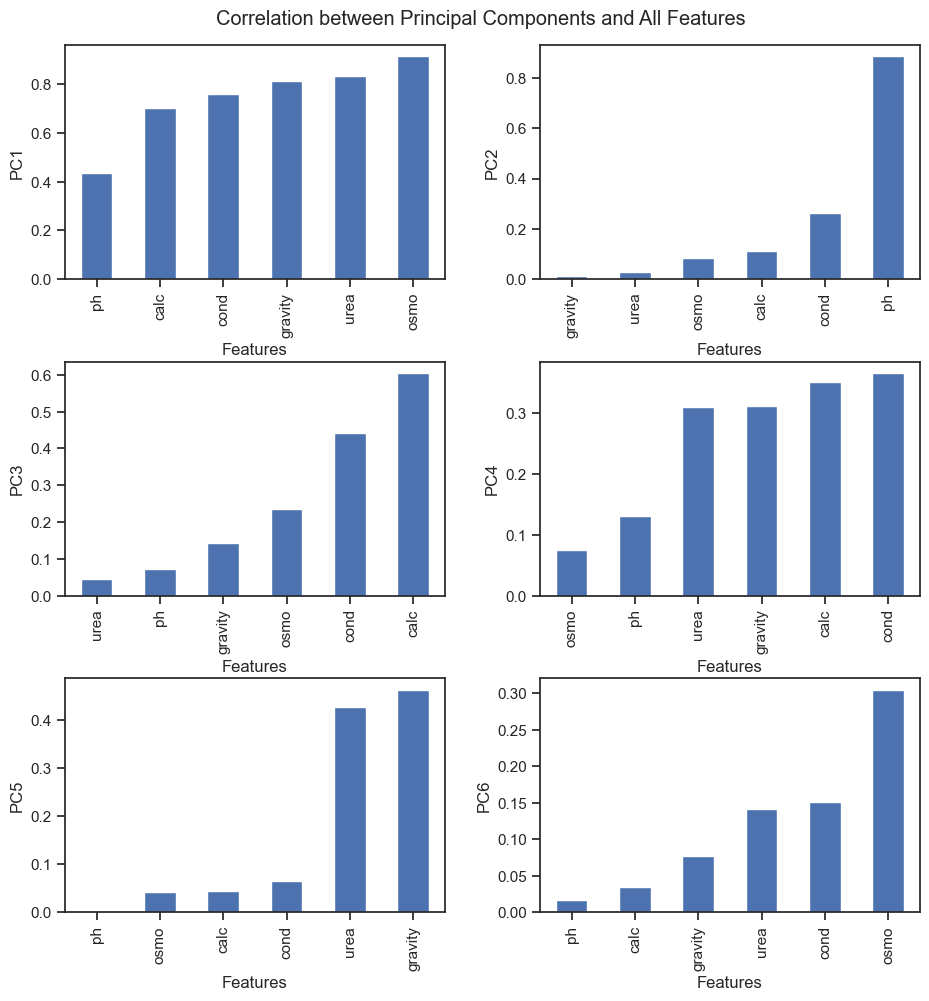

In [71]:
fig,ax = plt.subplots(3,2,figsize=(10,10))
fig.tight_layout(pad=3.0)

# Create the first subfigure
abs(X.corrwith(principal_components.PC1, axis = 0)).sort_values().plot(kind = "bar",ax=ax[0,0])
ax[0,0].set_ylabel('PC1')
ax[0,0].set_xlabel('Features')
# Create the second subfigure
abs(X.corrwith(principal_components.PC2, axis = 0)).sort_values().plot(kind = "bar",ax=ax[0,1])
ax[0,1].set_ylabel('PC2')
ax[0,1].set_xlabel('Features')
# Create the third subfigure
abs(X.corrwith(principal_components.PC3, axis = 0)).sort_values().plot(kind = "bar",ax=ax[1,0])
ax[1,0].set_ylabel('PC3')
ax[1,0].set_xlabel('Features')
# Create the fourth subfigure
abs(X.corrwith(principal_components.PC4, axis = 0)).sort_values().plot(kind = "bar",ax=ax[1,1])
ax[1,1].set_ylabel('PC4')
ax[1,1].set_xlabel('Features')
# Create the fifth subfigure
abs(X.corrwith(principal_components.PC5, axis = 0)).sort_values().plot(kind = "bar",ax=ax[2,0])
ax[2,0].set_ylabel('PC5')
ax[2,0].set_xlabel('Features')
# Create the sixth subfigure
abs(X.corrwith(principal_components.PC6, axis = 0)).sort_values().plot(kind = "bar",ax=ax[2,1])
ax[2,1].set_ylabel('PC6')
ax[2,1].set_xlabel('Features')

fig.suptitle('Correlation between Principal Components and All Features')
plt.show()

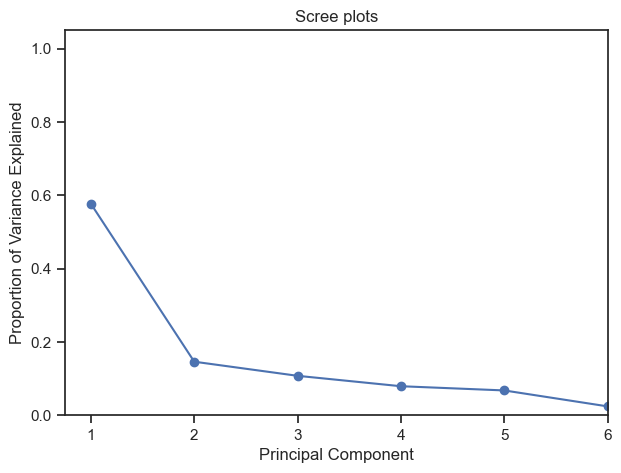

In [81]:
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4,5,6],pca.explained_variance_ratio_, '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6])
plt.title("Scree plots")
plt.show()

In [76]:
# How many PC's do you need to use to get upto 90% explained variance?
round(sum(pca.explained_variance_ratio_[0:4]),3)

0.909

From the scree plot and explained variance ratios of each PC, I selected PC1, PC2, PC3, PC4 to be used in the models since they account for 90% of the variation in the data. For these PCs, I saw that they are highly correlated with certain features:

1. PC1 - all features except for pH
2. PC2 - pH
3. PC3 - calc and cond
4. PC4 - urea, gravity, calc, cond

As an added benefit, PCA allowed us to reduce variable dimensions from 6 down to 4. 




## Prepare Model

In [ ]:
#join PC with original data
train = train.join(principal_components[['PC1','PC2','PC3','PC4']])

In [142]:
# Define the predictors
X = train[['PC1','PC2','PC3','PC4']]
# Define the target
y = train["target"]

In [88]:
# Use training and testing to split the data. Use 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Training dataset proportion:\n",round(y_train.value_counts(normalize=True).sort_index(),3),"\n")
print("Testing dataset proportion:\n",round(y_test.value_counts(normalize=True).sort_index(),3))

Training dataset proportion:
 0    0.559
1    0.441
Name: target, dtype: float64 

Testing dataset proportion:
 0    0.542
1    0.458
Name: target, dtype: float64


In [186]:
#Create a Kfold cross validation object with 5 folds using the KFold function.
cvdata = KFold(n_splits=5, random_state=0,shuffle=True)

In [98]:
# Create accuracy metric function
def fpr_tpr_pr(cm):
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    FPR = FP/(FP+TN)
    TPR = TP/(TP+FN)
    precision = TP/(TP + FP)
    print("The false positive rate is", round(FPR,2))
    print("The true positive rate is", round(TPR,2))
    print("The precision is", round(precision,2))

## Random Forest

In [204]:
rf = RandomForestClassifier(random_state=42)

# Define hyperparameters to tune
param_dist = {
    'n_estimators': [100,300],
    'max_depth': [3,5,7],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', 'log2', None]
}

# Tune random forest using Grid Search
clf = GridSearchCV(rf, param_dist)

In [214]:
#best hyperparameter
print(f'Best hyperparameters: {clf.best_params_}')

Best hyperparameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [205]:
# Fit random forest
clf = clf.fit(X_train, y_train)

In [206]:
# since we need to compute the roc curve, we first need to predict the probabilites
predrf_probs_train=clf.predict_proba(X_train)
predrf_probs_test = clf.predict_proba(X_test)

In [208]:
# Predict the target variable for new data
y_pred_rf = clf.predict(X_test)

### Confusion Matrix

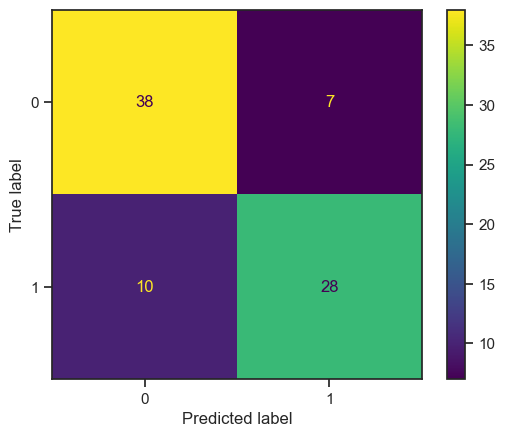

In [209]:
cm1 = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()

### Accuracy Metrics

In [210]:
fpr_tpr_pr(cm1)

The false positive rate is 0.16
The true positive rate is 0.74
The precision is 0.8


### ROC Curve

C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


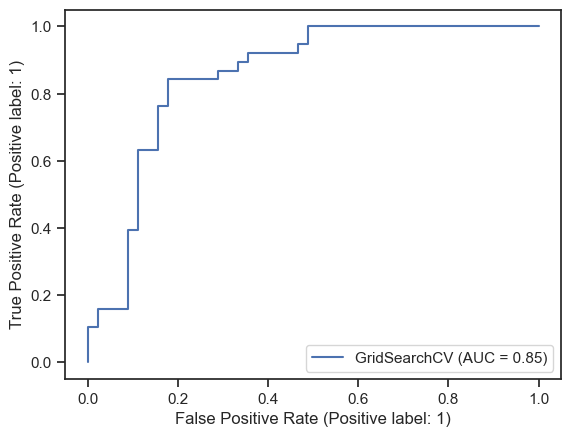

In [212]:
metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

In [211]:
# training auc
print("training auc:",roc_auc_score(y_train, predrf_probs_train[:,1]))

#testing auc
print("testing auc:",roc_auc_score(y_test, predrf_probs_test[:,1]))

training auc: 0.9953720844131804
testing auc: 0.8532163742690058


## K Neighbors Classifier

In [187]:
# find best k neighbors based on Rsquared
Rsquared = []
for k in range(1,20):   
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=cvdata)
    Rsquared.append(scores.mean())

C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

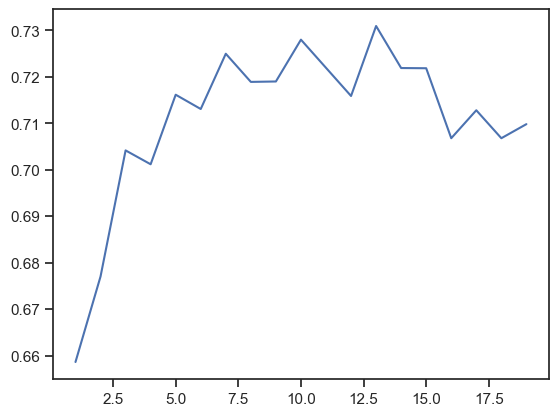

In [188]:
plt.plot(range(1,20),Rsquared)

In [189]:
print("Best K value:",range(1,51)[np.argmax(Rsquared)])

Best K value: 13


In [190]:
# model data based on best k value
knn = KNeighborsClassifier(n_neighbors=range(1,51)[np.argmax(Rsquared)])

In [191]:
# fit model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [192]:
# since we need to compute the roc curve, we first need to predict the probabilites
predknn_probs_train=knn.predict_proba(X_train)
predknn_probs_test = knn.predict_proba(X_test)

In [193]:
# Predict the target variable for new data
y_pred_knn = knn.predict(X_test)

C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### Confusion Matrix

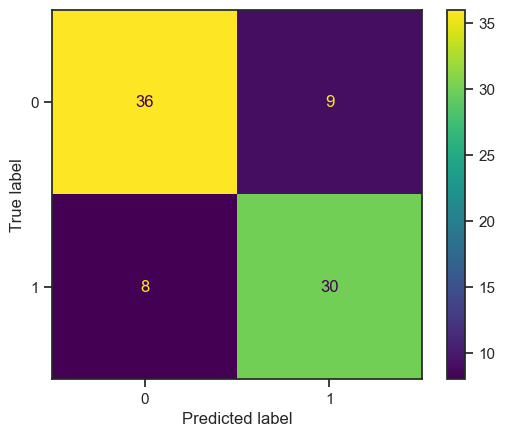

In [194]:
cm3 = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot()

### Accuracy Metrics

In [195]:
fpr_tpr_pr(cm3)

The false positive rate is 0.2
The true positive rate is 0.79
The precision is 0.77


### ROC Curve

C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


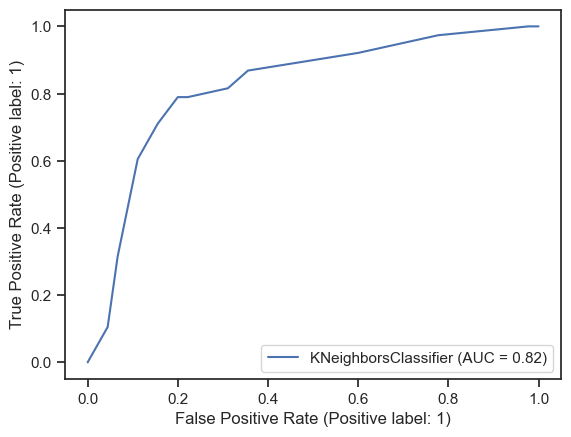

In [196]:
metrics.plot_roc_curve(knn, X_test, y_test) 
plt.show()

In [197]:
# training auc
print("training auc:",roc_auc_score(y_train, predknn_probs_train[:,1]))

#testing auc
print("testing auc:",roc_auc_score(y_test, predknn_probs_test[:,1]))

training auc: 0.8270270270270269
testing auc: 0.8230994152046783


## Logistic Regression

In [167]:
lr = LogisticRegression(penalty='none')
lr.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [168]:
# since we need to compute the roc curve, we first need to predict the probabilites
predlr_probs_train=lr.predict_proba(X_train)
predlr_probs_test = lr.predict_proba(X_test)

In [179]:
# Predict the target variable for new data
y_pred_lr = lr.predict(X_test)

### Confusion Matrix

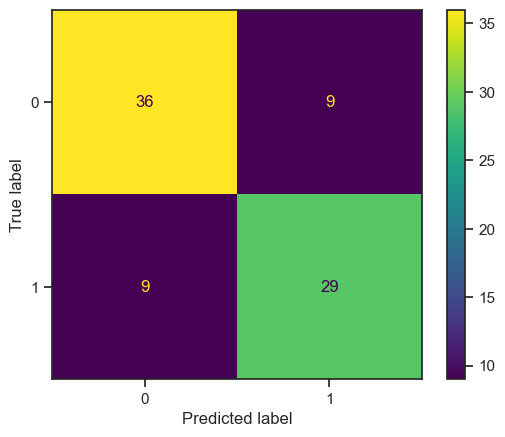

In [181]:
cm2 = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()

### Accuracy Metrics

In [182]:
fpr_tpr_pr(cm2)

The false positive rate is 0.2
The true positive rate is 0.76
The precision is 0.76


### ROC Curve

C:\Users\Surf-ace\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


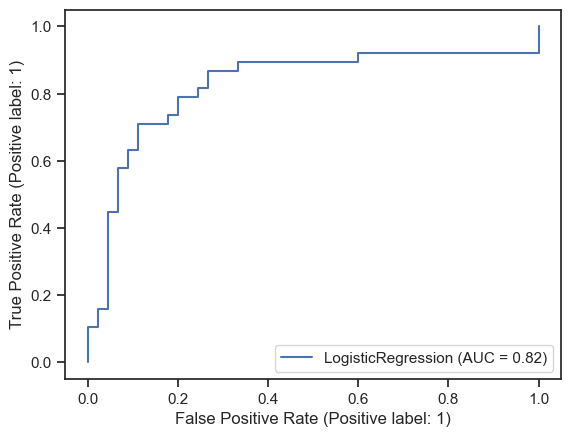

In [156]:
metrics.plot_roc_curve(lg, X_test, y_test) 
plt.show()

In [169]:
# training auc
print("training auc:",roc_auc_score(y_train, predlr_probs_train[:,1]))

#testing auc
print("testing auc:",roc_auc_score(y_test, predlr_probs_test[:,1]))

training auc: 0.7837097371343946
testing auc: 0.8245614035087719


## Conclusion

The table below summarizes results of all models rounded to the nearest 2 decimal places. However, it should also be noted that we have not completely explored all machine learning models. There are many robust ensemble models like XGBClassifier, Gradient Boosting, or a combination of all of the mentioned models in this project.

| Models | False Positive Rate | True Positive Rate | Precision | Training AUC | Testing AUC |
| --- | --- | --- | --- | --- | --- |
| Random Forest | 0.16 | 0.74 | 0.80 | 1.00 | 0.85 |
| K Neighbors Classifier | 0.20 | 0.79 | 0.77 | 0.83 | 0.82 |
| Logistic Regression | 0.20 | 0.76 | 0.76 | 0.78 | 0.82 |

False positive rate shows the probability of presence of kidney stones will be given when the true value is absence of kidney stones. Random Forest outperforms other models at 16% false positive rate. 

True positive rate shows the probability of an actual presence of kidney stones will test for presence of kidney stones. K Neighbors Classifier outperforms other models at 79% true positive rate.

Precision shows that out of all the specimens who were identified to have presence of kidney stones, how many really have presence of kidney stones. Random Forest outperforms other models at 80% precision.

The benchmark for AUC is a random classifier with 0.5 AUC, therefore all models have relatively good AUC results for both training and testing dataset. Once again, Random Forest outperforms other models with almost perfect training AUC and the highest testing AUC. However, this also shows us that this model is likely overfit and the more similar AUC results of K Neighbors Classifier might be more desirable.

Based on the results above, we can rank the model as follow and it appears that Random Forest is the best model to predict the probability of presence of kidney stones.

| Models | False Positive Rate | True Positive Rate | Precision | Training AUC | Testing AUC |
| --- | --- | --- | --- | --- | --- |
| Random Forest | **1st** | 3rd | **1st** | **1st** | **1st** |
| K Neighbors Classifier | 2nd (tied) | **1st** | 2nd | 2nd | 2nd (tied) |
| Logistic Regression | 2nd (tied) | 2nd | 3rd | 3rd | 2nd (tied) |

## References

1. https://labs.selfdecode.com/blog/urine-ph/#:~:text=The%20normal%20range%20of%20urine,affect%20the%20pH%20of%20urine.
2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7423618/#:~:text=Analyzing%20electrolytes%20in%20urine%2C%20such,tract%20infection%2C%20and%20cystic%20fibrosis.
3. https://www.mountsinai.org/health-library/tests/osmolality-urine-test#:~:text=An%20osmolality%20test%20measures%20the,congestive%20heart%20failure%20or%20shock.
4. https://www.ucsfhealth.org/medical-tests/calcium---urine#:~:text=Normal%20Results,(mmol%2F24%20hours).
5. https://www.ucsfhealth.org/medical-tests/urine-specific-gravity-test#:~:text=The%20normal%20range%20for%20urine,of%20your%20specific%20test%20results.
